In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

In [23]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])


def contactMatrix(t):   
    return C

# duration of simulation and data file
Tf = 100;  
Nt=Tf+1; 

beta = 0.02
alpha = 0.2
gIa = 1/7 
gIs = 1/7 
fsa = 1


# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']

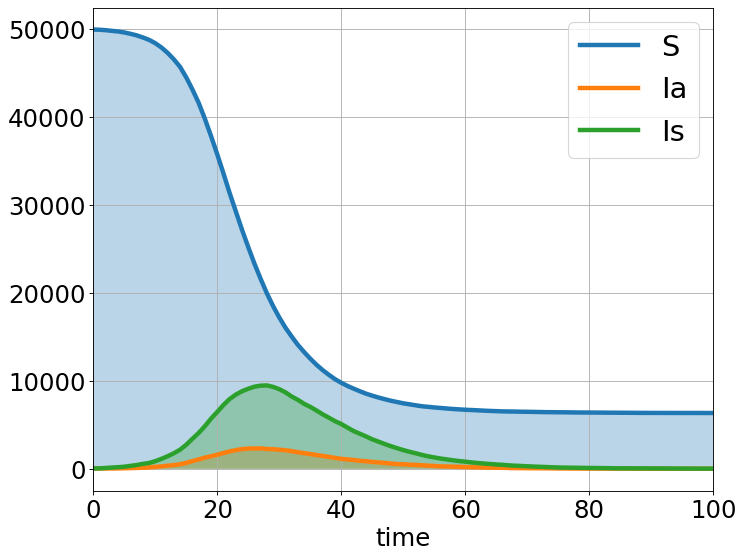

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [24]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
x = (data_array[:Nf_inference]).astype('float')

In [25]:
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}

model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"]]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}

In [26]:
# a filter that sums over all the infected people for each age group
fltr = np.kron([0, 1, 1],np.identity(M))
print(fltr)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# initialise the estimator 
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni, lyapunov_method='euler')

# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)
print(logp) 

[[0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]
270.5330807612575


In [27]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4
param_priors = {
    'betaIa':{
        'mean': 0.005, 
        'std': 0.003, 
        'bounds': [eps, 0.1]
    }, 
    'betaIs':{
        'mean': 0.02,  
        'std': 0.02, 
        'bounds': [eps, 0.1]
    }, 
    'gIa':{
        'mean': 0.2, 
        'std': 0.1,
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': 0.15,
        'std': 0.1, 
        'bounds': [eps, 0.6]
    }
}

In [43]:
Ia0_g = (Ia0+3)
Ia0_std = Ia0_g
Ia0_b = np.array([[0.1, 100]]*M)

S0_g = (S0-3)
S0_std = Ia0_std*3
S0_b = [(100, N) for N in Ni]

init_priors = {
    'independent':{
        'fltr': np.repeat([True, True, False], M), 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S0_std, *Ia0_std], 
        'bounds': [*S0_b, *Ia0_b]
    }
}

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)
start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,
                                    use_gradient=True, tangent=True, global_max_iter=30, global_atol=10, 
                                    enable_global=True, verbose=True, ftol=ftol) 
end_time = time.time() 
print(end_time-start_time)

Looking for saved derivative functions...
Loaded.
Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=935632005, Thu Jul 16 18:39:07 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.012712369177587e+03 1.0e+00 1.10e+00  4e-03  8e+01 0:00.2
    2     32 3.720705243177514e+02 1.5e+00 1.10e+00  4e-03  7e+01 0:00.3
    3     48 5.999464021081295e+02 1.6e+00 1.02e+00  4e-03  7e+01 0:00.5
   22    352 2.798046748939232e+02 7.9e+00 5.27e-01  2e-03  4e+01 0:03.6
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  279.80467489392316
Starting local minimisation...
Optimal value (local minimisation):  277.9739068711128
9.107800960540771


In [44]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = res['map_params_dict']
print(best_estimates)

True parameters:
{'betaIa': 0.004, 'betaIs': 0.016, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285}

Inferred parameters:
{'betaIa': 0.002997875786196439, 'betaIs': 0.017136554569121124, 'gIa': 0.10298186528215743, 'gIs': 0.15266988514399818}


In [45]:
# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  
start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,
                                    use_gradient=False, tangent=True, global_max_iter=30, global_atol=10, 
                                    enable_global=True, verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time-start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=4061549052, Thu Jul 16 18:39:24 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.399341910873056e+03 1.0e+00 1.16e+00  4e-03  9e+01 0:00.2
    2     32 3.248314203538191e+04 1.3e+00 1.43e+00  5e-03  1e+02 0:00.3
    3     48 6.345737142452520e+03 1.4e+00 1.74e+00  6e-03  1e+02 0:00.5
   25    400 3.317769759643045e+02 4.6e+00 9.36e-01  3e-03  7e+01 0:03.5
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  298.2124014343452
Starting local minimisation...
Optimal value (local minimisation):  277.4252053737336
6.892477035522461


In [46]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = res['map_params_dict']
print(best_estimates)

True parameters:
{'betaIa': 0.004, 'betaIs': 0.016, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285}

Inferred parameters:
{'betaIa': 0.002934901017623372, 'betaIs': 0.017178523070602664, 'gIa': 0.13016841947536026, 'gIs': 0.14574976639948062}


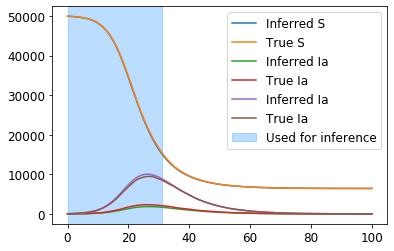

In [47]:
Nf = 101
Tf = Nf-1

map_x0 = res['map_x0']

estimator.set_det_model(best_estimates)
x_det = estimator.integrate(x[0].astype('float'), 0, Tf, Nf)
x = data['X']
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ia')
plt.axvspan(0, Nf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 